<a href="https://colab.research.google.com/github/KimJisanER/medical_ai/blob/main/KOHI_221001_%EC%A0%84%EC%B2%98%EB%A6%AC%EC%8B%A4%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#KOHI 2022 10/1 실습 코드
## 실습 내용


*   데이터 클랜징 및 Cohort 분석
  * 데이터 클랜징 - 이상값 제거, Outlier 처리
  * Cohort 분석 - 연령대별 통계분석, 성별에 따른 통계분석, ICU Type에 따른 통계분석
*   데이터 레이블링 및 학습 데이터 생성
  * 데이터 레이블링 - 사망, 저혈압
  * 시계열 형태의 학습 데이터 만들기



# 데이터 클랜징 - 이상값 제거, Outlier 처리

In [1]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [2]:
# Data Download
FILE_IDS = ["1-91Ad_3yQQ0T6ROnlxqbbgEFc6tiZAsY",
            "1-RbUxW2hF2ayWDhkMqGfKZvzEKwiLqQX",
            "1r76_XuYikaeswLAIpIbPpkx_kXgJob3a",
            "1-I25PxwI6qpDrNtDJD_jEnLl_MXh9hjH",
            "1-3YZEp8xFYplMjvFSfzb637WwA8OwW_2",
            "1-HhOwcDMse4BevovRkxOBICe5zZ3YraZ",
            "1GO4MIIzgNOB8zDvtgldU5JdLZbMlnczz"]
FILE_NAMES = ['PATIENTS.csv', 'LABEVENTS.csv', 'CHARTEVENTS.csv',
              'D_ITEMS.csv', 'D_LABITEMS.csv', 'ADMISSIONS.csv', 'ICUSTAYS.csv']
for f_id, f_name in tqdm(zip(FILE_IDS, FILE_NAMES), desc="Download Files...", total=len(FILE_IDS), ncols=75):
  download_file = drive.CreateFile({'id': f_id})
  download_file.GetContentFile(f_name)

Download Files...: 100%|█████████████████████| 7/7 [00:43<00:00,  6.18s/it]


In [3]:
import os
import csv
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

#ITEMID for MIMIC-III
VITAL_SIGNS = {'PULSE': ['220045', '211'],
               'RESP': ['220210', '618'],
               'SBP': ['220050', '220179', '225309', '51', '455'],
               'DBP': ['220051', '220180', '225310', '8368', '8441'],
               'FiO2': ['223835', '189', '190'],
               'MAP': ['220052', '1321', '438']
               }
LABS = {'BILIRUBIN': ['50885'],
        'LACTATE': ['50813'],
        'pH': ['50820', '50831'],
        'SODIUM': ['50983'],
        'POTASSIUM': ['50971'],
        'CREATININE': ['50912'],
        'WBC': ['51301'],
        'HEMATOCRIT': ['51221']
        }
ITEM_IDS = {
    '220045': 'PULSE', 
    '211': 'PULSE',
    '220210': 'RESP', 
    '618': 'RESP',
    '220050': 'SBP',
    '220179': 'SBP',
    '225309': 'SBP',
    '51': 'SBP',
    '455': 'SBP',
    '220051': 'DBP',
    '220180': 'DBP',
    '225310': 'DBP',
    '8368': 'DBP',
    '8441': 'DBP',
    '223835': 'FiO2',
    '189': 'FiO2',
    '190': 'FiO2',
    '220052': 'MAP',
    '1321': 'MAP',
    '438': 'MAP',
    '50885': 'BILIRUBIN',
    '50813': 'LACTATE',
    '50820': 'pH',
    '50831': 'pH',
    '50983': 'SODIUM',
    '50971': 'POTASSIUM',
    '50912': 'CREATININE',
    '51301': 'WBC',
    '51221': 'HEMATOCRIT'
}

In [4]:
# Load Chartevents and Labevents Table
CHARTEVENTS = pd.read_csv('CHARTEVENTS.csv', low_memory=False, dtype='str', keep_default_na=False) #string 형식으로 통일해서 불러옴 , #null 빈 문자열 형식으로 불러옴
LABEVENTS = pd.read_csv('LABEVENTS.csv', low_memory=False, dtype='str', keep_default_na=False)

In [5]:
# Make Checking float value function
def is_float(value):
  try:
    float(value)
    return True
  except:
    return False

In [6]:
# Get Only float values for VitalSign
float_VS = CHARTEVENTS[CHARTEVENTS['VALUENUM'].apply(lambda x: is_float(x))].reset_index()
float_VS

,index,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ITEMID,CHARTTIME,STORETIME,CGID,VALUE,VALUENUM,VALUEUOM,WARNING,ERROR,RESULTSTATUS,STOPPED
0,0,147286,1257,160336,237955,220734,2196-11-21 12:27:00,2196-11-21 13:43:00,20889,6,6,units,0,0,,
1,1,147287,1257,160336,237955,227471,2196-11-21 12:27:00,2196-11-21 13:19:00,20889,1.01,1.01,,0,0,,
2,2,147288,1257,160336,237955,223834,2196-11-21 13:00:00,2196-11-21 15:21:00,15652,10,10,L/min,0,0,,
3,3,147289,1257,160336,237955,223835,2196-11-21 13:00:00,2196-11-21 15:21:00,15652,100,100,,0,0,,
4,4,147290,1257,160336,237955,220179,2196-11-21 13:21:00,2196-11-21 13:25:00,15652,139,139,mmHg,0,0,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3100999,7241337,329919200,99312,150103,293902,224055,2157-05-07 08:04:00,2157-05-07 09:05:00,17250,Occasionally Moist,3,,0,0,,
3101000,7241338,329919201,99312,150103,293902,224056,2157-05-07 08:04:00,2157-05-07 09:05:00,17250,Bedfast,1,,0,0,,
3101001,7241339,329919202,99312,150103,293902,224057,2157-05-07 08:04:00,2157-05-07 09:05:00,17250,Completely Immobile,1,,0,0,,
3101002,7241340,329919203,99312,150103,293902,224058,2157-05-07 08:04:00,2157-05-07 09:05:00,17250,Probably Inadequate,2,,0,0,,


In [7]:
# Get Only float values for Lab
float_LAB = LABEVENTS[LABEVENTS['VALUENUM'].apply(lambda x: is_float(x))].reset_index()
float_LAB

,index,ROW_ID,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE,VALUENUM,VALUEUOM,FLAG
0,0,24146,55,,51248,2138-05-28 18:14:00,27.0,27,pg,
1,1,24147,55,,51249,2138-05-28 18:14:00,33.0,33,%,
2,2,24148,55,,51250,2138-05-28 18:14:00,82,82,fL,
3,3,24149,55,,51254,2138-05-28 18:14:00,4.5,4.5,%,
4,4,24150,55,,51256,2138-05-28 18:14:00,66.7,66.7,%,
...,...,...,...,...,...,...,...,...,...,...
550936,615323,27799406,99231,102589,51275,2149-11-12 12:02:00,29.0,29,sec,
550937,615324,27799407,99231,102589,50861,2149-11-13 09:53:00,21,21,IU/L,
550938,615325,27799408,99231,102589,50863,2149-11-13 09:53:00,59,59,IU/L,
550939,615326,27799409,99231,102589,50868,2149-11-13 09:53:00,11,11,mEq/L,


In [8]:
# Print examples of non-float values for VitalSign and Lab
nonfloat_VS = CHARTEVENTS[CHARTEVENTS['VALUENUM'].apply(lambda x: not is_float(x))].reset_index()
print(nonfloat_VS.head(5))

nonfloat_LAB = LABEVENTS[LABEVENTS['VALUENUM'].apply(lambda x: not is_float(x))].reset_index()
print(nonfloat_LAB.head(5))

    index    ROW_ID SUBJECT_ID HADM_ID ICUSTAY_ID ITEMID            CHARTTIME  \
0  615352  34514448         87  190659     277633   3519  2191-03-17 00:30:00   
1  615355  34514451         87  190659     277633   3559  2191-03-17 00:30:00   
2  615356  34514452         87  190659     277633   3568  2191-03-17 00:30:00   
3  615357  34514453         87  190659     277633   3572  2191-03-17 00:30:00   
4  615363  34514459         87  190659     277633   3607  2191-03-17 00:30:00   

             STORETIME   CGID        VALUE VALUENUM VALUEUOM WARNING ERROR  \
0  2191-03-17 01:24:00  20296  Symmetrical                                   
1  2191-03-17 01:24:00  20296         None                                   
2  2191-03-17 01:24:00  20296       Normal                                   
3  2191-03-17 01:24:00  20296       Stable                                   
4  2191-03-17 01:24:00  20296    Subcostal                                   

  RESULTSTATUS   STOPPED  
0               N

In [9]:
# Get input features only
INPUT_ITEMIDS = list()
for kk, vv in VITAL_SIGNS.items():
  INPUT_ITEMIDS += vv
for kk, vv in LABS.items():
  INPUT_ITEMIDS += vv

INPUT_ITEMIDS = set(INPUT_ITEMIDS)
print(INPUT_ITEMIDS)

input_VS = float_VS[float_VS['ITEMID'].isin(INPUT_ITEMIDS)].reset_index()
input_LAB = float_LAB[float_LAB['ITEMID'].isin(INPUT_ITEMIDS)].reset_index()

print(input_VS)
print(input_LAB)

{'225310', '438', '8441', '1321', '220210', '189', '50813', '50971', '51', '220180', '50831', '225309', '220179', '211', '51301', '50885', '51221', '8368', '618', '455', '50820', '220045', '50983', '220051', '190', '50912', '220050', '223835', '220052'}
        level_0    index     ROW_ID SUBJECT_ID HADM_ID ICUSTAY_ID  ITEMID  \
0             3        3     147289       1257  160336     237955  223835   
1             4        4     147290       1257  160336     237955  220179   
2             5        5     147291       1257  160336     237955  220180   
3             7        7     147293       1257  160336     237955  220210   
4             8        8     147294       1257  160336     237955  220045   
...         ...      ...        ...        ...     ...        ...     ...   
603541  2806811  5569641  255155407      32292  196589     241669    8441   
603542  2806816  5569650  255155416      32292  196589     241669    8441   
603543  2806821  5569655  255155421      32292  19658

### Outlier 제거 실습


1.   정상 범위를 이용한 Outlier 제거
2.   IQR를 이용한 Outlier 제거



In [10]:
# 정상범위를 이용한 Outlier 제거
# Feature별 정상범위 설정
feature_range = dict({
    'AGE': (18, 90),
    'PULSE': (0, 300),
    'RESP': (0, 120),
    'SBP': (0, 300),
    'DBP': (0, 300),
    'MAP': (0, 300),
    'FiO2': (0, 100),
    'BILIRUBIN': (0, 75),
    'LACTATE': (0, 20),
    'SODIUM': (0, 500),
    'POTASSIUM': (0, 15),
    'CREATININE': (0, 20),
    'HEMATOCRIT': (0, 100),
    'WBC': (0, 100),
    'pH': (0, 14),
  })

In [11]:
# Make function that checking normal range for each value
def is_in_range(value_ranges, feature_key, feature_value):
  if feature_key not in value_ranges:
      raise AssertionError(feature_key)
  value_min, value_max = value_ranges[feature_key]
  return value_min <= feature_value <= value_max

In [12]:
invalid_input_vs = list()
invalid_input_lab = list()

for (idx, row) in tqdm(input_VS.iterrows(), desc='Filtering VS'):
  itemID = row['ITEMID']
  feature_name = ITEM_IDS[itemID]
  feature_value = float(row['VALUENUM'])
  if is_in_range(feature_range, feature_name, feature_value):
    continue
  else:
    invalid_input_vs.append(idx)

for (idx, row) in tqdm(input_LAB.iterrows(), desc='Filtering LAB'):
  itemID = row['ITEMID']
  feature_name = ITEM_IDS[itemID]
  feature_value = float(row['VALUENUM'])
  if is_in_range(feature_range, feature_name, feature_value):
    continue
  else:
    invalid_input_lab.append(idx)

Filtering VS: 603546it [00:54, 10983.42it/s]
Filtering LAB: 110736it [00:09, 11471.07it/s]


In [13]:
print(len(invalid_input_vs))
print(len(input_VS))
valid_input_VS = input_VS.drop(input_VS.index[invalid_input_vs])
print(len(valid_input_VS))

print(len(invalid_input_lab))
print(len(input_LAB))
valid_input_LAB = input_LAB.drop(input_LAB.index[invalid_input_lab])
print(len(valid_input_LAB))

136
603546
603410
22
110736
110714


여기까지 진행을 했고 그다음에 이 밑에 내용은 이제 이것도 이제 나중에 뒤에서 실습을 진행하는 데 좀 편리하게 하기 위해서 진행하는 부분이라고 보시면 되겠는데요 바이탈 사인이랑 이벤트를 그러니까 전체 테이블을 다 가지고 나중에 환자 단위로 그 값을 가지고 오고 하다 보면 이게
시간이 오래 걸리는 문제가 있어서 그 전에 앞서서 각 hadm id를 기준으로 내원 번호를 기준으로 해당 내원번호를 갖는 바이탈 사인 랩만 따로 따로 추출해서 더 작은 단위의 테이블로 미리 변환을 해놓는 부분이라고 보시면 될 것 같습니다 그래서 어드미션 테이블로부터 hadm id 전체를 가지고 오고
매번 전체 테이블을 다 서칭 할 필요가 없이 그 해당 내원번호를 갖는 테이블만 서칭을 하면 돼서 속도가 훨씬 빨라지고요 그리고 나중에는 이렇게 데이터들을 만들어 놓으시면 hadm id를 기준으로 해서 그냥 멀티프로세싱을 돌려서 동시에 여러 hadm id에 대해서 그냥 다 처리를 할 수 있어요

In [14]:
# split features by hadm_id
hadm_VS = dict()
hadm_LAB = dict()

admissions = pd.read_csv('ADMISSIONS.csv', low_memory=False, dtype='str', keep_default_na=False)
hadm_ids = admissions['HADM_ID'].values

for hadm_id in tqdm(hadm_ids, desc='Split Features by HADM_ID'):
  vs = valid_input_VS[valid_input_VS['HADM_ID'] == hadm_id]
  lab = valid_input_LAB[valid_input_LAB['HADM_ID'] == hadm_id]

  hadm_VS[hadm_id] = vs
  hadm_LAB[hadm_id] = lab


  #해당 hadm id만 불러올 수 있어 여러모로 편리한 방법

Split Features by HADM_ID: 100%|██████████| 1262/1262 [01:13<00:00, 17.24it/s]


In [16]:
# IQR을 이용한 Outlier 제거
# Feautre별로 IQR 구하기, Box Plot 그려보기
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline 
#colab 안에서 plot을 표시해주기 위한 line

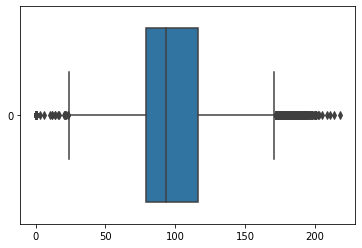

In [17]:
fig1, ax1 = plt.subplots()
sns.boxplot(data = float_VS[float_VS['ITEMID'].isin(VITAL_SIGNS['PULSE'])]['VALUENUM'].values, ax=ax1, orient='h') #orient h 삭제하면 세로로 그려짐

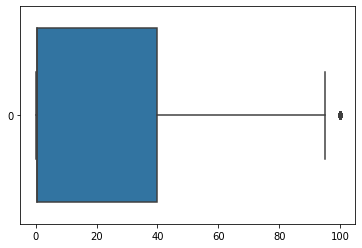

In [18]:
fig1, ax1 = plt.subplots()
sns.boxplot(data = float_VS[float_VS['ITEMID'].isin(VITAL_SIGNS['FiO2'])]['VALUENUM'].values, ax=ax1, orient='h') #orient h 삭제하면 세로로 그려짐

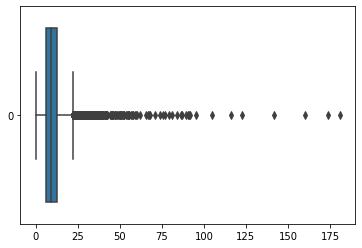

In [19]:
fig1, ax1 = plt.subplots()
sns.boxplot(data = float_LAB[float_LAB['ITEMID'].isin(LABS['WBC'])]['VALUENUM'].values, ax=ax1, orient='h') #orient h 삭제하면 세로로 그려짐

In [20]:
def get_min_max_iqr(values):
  q1 = np.quantile(values, 0.25)
  q3 = np.quantile(values, 0.75)
  iqr = q3 - q1
  min = q1 - (1.5 * iqr)
  max = q3 + (1.5 * iqr)
  return min, max

In [21]:
#IQR을 이용한 Feature별 Range 구하기
def make_feature_range_iqr(feature_range, values, feature_name):
  min, max = get_min_max_iqr(values)
  feature_range[feature_name] = (min, max)
  return feature_range

feature_names = list(VITAL_SIGNS.keys()) + list(LABS.keys())
feature_range = dict()

for feature_name in feature_names:
  if feature_name in VITAL_SIGNS:
    values = float_VS[float_VS['ITEMID'].isin(VITAL_SIGNS[feature_name])]['VALUENUM'].values
  elif feature_name in LABS:
    values = float_LAB[float_LAB['ITEMID'].isin(LABS[feature_name])]['VALUENUM'].values
  
  values = values.astype('float32')
  feature_range = make_feature_range_iqr(feature_range, values, feature_name)

feature_range

{'PULSE': (23.5, 171.5),
 'RESP': (4.0, 36.0),
 'SBP': (54.5, 186.5),
 'DBP': (21.5, 97.5),
 'FiO2': (-58.99999998509884, 99.3999999910593),
 'MAP': (37.5, 121.5),
 'BILIRUBIN': (-3.0500000566244125, 6.150000110268593),
 'LACTATE': (-1.1999998092651367, 5.199999809265137),
 'pH': (7.164999723434448, 7.605000257492065),
 'SODIUM': (127.0, 151.0),
 'POTASSIUM': (2.649999976158142, 5.450000166893005),
 'CREATININE': (-0.6500000655651093, 2.950000077486038),
 'WBC': (-3.049999475479126, 22.149999380111694),
 'HEMATOCRIT': (17.2375009059906, 44.537498235702515)}

In [22]:
def is_in_range_iqr(value_ranges, feature_key, feature_value):
  if feature_key not in value_ranges:
      raise AssertionError(feature_key)
  value_min, value_max = value_ranges[feature_key]
  return value_min <= feature_value <= value_max

# 정규식 실습

In [23]:
import re

sample_txt = "Hello everyone, this is practical session for KOHI2022. 2022-10-01"

print("[a-z]:", re.findall("[a-z]", sample_txt))
print("[a-z]+:", re.findall("[a-z]+", sample_txt))
print("[0-9]:", re.findall("[0-9]", sample_txt))
print("[0-9]+:", re.findall("[0-9]+", sample_txt))
print("[A-Z]:", re.findall("[A-Z]", sample_txt))
print("[a-zA-Z]+:", re.findall("[a-zA-Z]+", sample_txt))
print("[\w]+:", re.findall("[\w]+", sample_txt))
print("[\d]+:", re.findall("[\d]+", sample_txt))

## Checking valid e-mail address
# def email_checking(email):
#   try:
#     if re.findall(r'[\w.-]+@[\w.-]+.\w+', email)[0] != email:
#       print('{}: It is not a valid E-mail address'.format(email))
#       return
#   except:
#       print('{}: It is not a valid E-mail address'.format(email))
#       return
#   print('{}: It is a valid E-mail address'.format(email))


def number_checking(number):
  try:
    if re.findall(r'^\d{3}-^\d{4}-^\d{4}', number)[0] != number:
      print('{}: It is not a valid number'.format(number))
      return
  except:
      print('{}: It is not a valid valid number'.format(number))
      return
  print('{}: It is a valid number'.format(number))



number_checking('010-8681-0000')

[a-z]: ['e', 'l', 'l', 'o', 'e', 'v', 'e', 'r', 'y', 'o', 'n', 'e', 't', 'h', 'i', 's', 'i', 's', 'p', 'r', 'a', 'c', 't', 'i', 'c', 'a', 'l', 's', 'e', 's', 's', 'i', 'o', 'n', 'f', 'o', 'r']
[a-z]+: ['ello', 'everyone', 'this', 'is', 'practical', 'session', 'for']
[0-9]: ['2', '0', '2', '2', '2', '0', '2', '2', '1', '0', '0', '1']
[0-9]+: ['2022', '2022', '10', '01']
[A-Z]: ['H', 'K', 'O', 'H', 'I']
[a-zA-Z]+: ['Hello', 'everyone', 'this', 'is', 'practical', 'session', 'for', 'KOHI']
[\w]+: ['Hello', 'everyone', 'this', 'is', 'practical', 'session', 'for', 'KOHI2022', '2022', '10', '01']
[\d]+: ['2022', '2022', '10', '01']
010-8681-0000: It is not a valid valid number


In [24]:
def is_float_regex(value):
  try:
    float(re.findall("\d+\.\d+|\d+", value)[0])
    return False
  except:
    return True


# Cohort 분석
## - Cohort 정의 & Patients Flow chart
## - Cohort 별 데이터 통계 작성

In [25]:
import pandas as pd
admissions = pd.read_csv('ADMISSIONS.csv')
print(admissions.head(5))
patients = pd.read_csv('PATIENTS.csv')
print(patients.head(5))

   ROW_ID  SUBJECT_ID  HADM_ID            ADMITTIME            DISCHTIME  \
0      54          55   190665  2136-04-03 18:35:00  2136-04-05 14:30:00   
1      83          82   110641  2150-06-24 23:31:00  2150-06-29 15:00:00   
2      90          87   190659  2191-02-25 20:30:00  2191-04-25 15:18:00   
3     198         148   199488  2107-09-05 14:58:00  2107-10-08 13:35:00   
4     630         505   116719  2154-03-30 14:59:00  2154-04-01 16:00:00   

  DEATHTIME ADMISSION_TYPE         ADMISSION_LOCATION   DISCHARGE_LOCATION  \
0       NaN      EMERGENCY  CLINIC REFERRAL/PREMATURE                 HOME   
1       NaN        NEWBORN  PHYS REFERRAL/NORMAL DELI                 HOME   
2       NaN        NEWBORN  PHYS REFERRAL/NORMAL DELI  SHORT TERM HOSPITAL   
3       NaN      EMERGENCY  TRANSFER FROM HOSP/EXTRAM                  SNF   
4       NaN      EMERGENCY  TRANSFER FROM HOSP/EXTRAM     HOME HEALTH CARE   

  INSURANCE LANGUAGE      RELIGION MARITAL_STATUS              ETHNICITY  

In [26]:
from datetime import datetime

NOT_CONVERTED = 'NOT_CONVERTED'

def str2datetime(s):
    def _convert(_s, _dformat):
        try:
            converted_dt = datetime.strptime(_s, _dformat)
        except Exception:
            return NOT_CONVERTED

        return converted_dt

    if isinstance(s, datetime):
        return s

    dformats = [
        '%Y-%m-%d %p %I:%M:%S',
        '%Y-%m-%d %H:%M:%S.%f',
        '%Y-%m-%d %H:%M:%S',
        '%Y-%m-%d %H:%M',
        '%y-%m-%d %H:%M',
        '%Y-%m-%d',
        '%Y%m%d',
        '%Y-%m-%d +%H:%M',
        '%Y%m%d %H%M',
        '%Y%m%d%H%M%S',
        ]

    s = s.split('.')[0]
    s = s.replace('오전', 'am').replace('오후', 'pm')
    for dformat in dformats:
        dt = _convert(s, dformat)
        if dt != NOT_CONVERTED:
            return dt

    return NOT_CONVERTED

In [27]:
# Inclusion Criteria
## AGE >= 18, First MAP > 65
## Make Patients DataFrame with SUBJECT_ID, HADM_ID, AGE, First MAP
admissions = pd.read_csv('ADMISSIONS.csv')
patients = pd.read_csv('PATIENTS.csv')
patients_info = admissions[['SUBJECT_ID', 'HADM_ID']]
patients_info['AGE'] = ''
patients_info['FIRST_MAP'] = ''

# Update Patient's AGE and MAP
for (idx, row) in tqdm(patients_info.iterrows(), desc='make patients info table'):
  subject_id = row['SUBJECT_ID']
  hadm_id = row['HADM_ID']
  admin_date = admissions[admissions['HADM_ID'] == hadm_id]['ADMITTIME'].values[0]
  dob = patients[patients['SUBJECT_ID'] == subject_id]['DOB'].values[0]
  age = int((str2datetime(admin_date) - str2datetime(dob)).total_seconds() / (3600. * 24 * 365))
  patients_info.loc[idx, 'AGE'] = age

  # If there are no map values, calculate map with sbp & dpb
  # MAP = SBP + 2 (DBP) / 3
  map_list = hadm_VS[str(hadm_id)][hadm_VS[str(hadm_id)]['ITEMID'].isin(VITAL_SIGNS['MAP'])]
  map_list.sort_values(by=['CHARTTIME'])
  if len(map_list) == 0:
    sbp_list = hadm_VS[str(hadm_id)][hadm_VS[str(hadm_id)]['ITEMID'].isin(VITAL_SIGNS['SBP'])]
    sbp_list.sort_values(by=['CHARTTIME'])
    dbp_list = hadm_VS[str(hadm_id)][hadm_VS[str(hadm_id)]['ITEMID'].isin(VITAL_SIGNS['DBP'])]
    dbp_list.sort_values(by=['CHARTTIME'])
    if (len(sbp_list) == 0) or (len(dbp_list) == 0):
      map = np.nan
    else:
      sbp = int(sbp_list['VALUENUM'].values[0])
      dbp = int(dbp_list['VALUENUM'].values[0])
      map = (sbp + (2*dbp)) / 3
  else:
    map = int(map_list['VALUENUM'].values[0])
  
  patients_info.loc[idx, 'FIRST_MAP'] = map

patients_info

make patients info table: 1262it [00:08, 148.04it/s]


,SUBJECT_ID,HADM_ID,AGE,FIRST_MAP
0,55,190665,64,104.0
1,82,110641,0,NaN
2,87,190659,0,NaN
3,148,199488,78,63.333333
4,505,116719,56,61.0
...,...,...,...,...
1257,99830,176834,49,86
1258,93784,172532,63,99
1259,95413,187979,55,80.333333
1260,98644,109643,49,75.0


In [28]:
# Find Included Patients and Exclueded Patients
total_patients_n = len(patients_info)
adult_patients = patients_info[patients_info['AGE'] >= 18]
adult_patients_n = len(adult_patients)
map_normal_patients = adult_patients[adult_patients['FIRST_MAP'] > 65]
map_normal_patients_n = len(map_normal_patients)

print('Total Patients Number: ', total_patients_n)
print('Total AGE >= 18 Patients Number: ', adult_patients_n)
print('\t Excluded by AGE: ', total_patients_n - adult_patients_n)
print('Total Normal MAP Patients Number: ', map_normal_patients_n)
print('\t Excluded by MAP: ', adult_patients_n - map_normal_patients_n)

Total Patients Number:  1262
Total AGE >= 18 Patients Number:  1109
	 Excluded by AGE:  153
Total Normal MAP Patients Number:  914
	 Excluded by MAP:  195


In [29]:
# Make Patients Group by Age
# Age Groups: <30, <40, <50, <60, <70, <80, <90, >=90
group_list = ['<30', '<40', '<50', '<60', '<70', '<80', '<90', '>=90']
age_group = dict()

for group in tqdm(group_list, desc='Grouping by Age'):
  if group == '<30':
    hadm_ids = map_normal_patients[map_normal_patients['AGE'] < 30]['HADM_ID'].values
    age_group[group] = hadm_ids
    print('# of Patients <30: ', len(hadm_ids))
  elif group == '<40':
    hadm_ids = map_normal_patients[map_normal_patients['AGE'] < 40]['HADM_ID'].values
    age_group[group] = hadm_ids
    print('# of Patients <40: ', len(hadm_ids))
  elif group == '<50':
    hadm_ids = map_normal_patients[map_normal_patients['AGE'] < 50]['HADM_ID'].values
    age_group[group] = hadm_ids
    print('# of Patients <50: ', len(hadm_ids))
  elif group == '<60':
    hadm_ids = map_normal_patients[map_normal_patients['AGE'] < 60]['HADM_ID'].values
    age_group[group] = hadm_ids
    print('# of Patients <60: ', len(hadm_ids))
  elif group == '<70':
    hadm_ids = map_normal_patients[map_normal_patients['AGE'] < 70]['HADM_ID'].values
    age_group[group] = hadm_ids
    print('# of Patients <70: ', len(hadm_ids))
  elif group == '<80':
    hadm_ids = map_normal_patients[map_normal_patients['AGE'] < 80]['HADM_ID'].values
    age_group[group] = hadm_ids
    print('# of Patients <80: ', len(hadm_ids))
  elif group == '<90':
    hadm_ids = map_normal_patients[map_normal_patients['AGE'] < 90]['HADM_ID'].values
    age_group[group] = hadm_ids
    print('# of Patients <90: ', len(hadm_ids))
  else:
    hadm_ids = map_normal_patients[map_normal_patients['AGE'] >= 90]['HADM_ID'].values
    age_group[group] = hadm_ids
    print('# of Patients >=90: ', len(hadm_ids))



Grouping by Age: 100%|██████████| 8/8 [00:00<00:00, 426.12it/s]

# of Patients <30:  48
# of Patients <40:  94
# of Patients <50:  200
# of Patients <60:  382
# of Patients <70:  565
# of Patients <80:  745
# of Patients <90:  875
# of Patients >=90:  39


In [30]:
# Calculate feature statistics for each Group of Patients
# PULSE
feature_statistics = dict()
feature_name = 'PULSE'
for group in tqdm(group_list, desc='Calculate feature statistics by Age Group'):
  group_hadm_ids = age_group[group]
  feature_values = list()
  for hadm_id in group_hadm_ids:
    vs_table = hadm_VS[str(hadm_id)]
    feature_list = list((vs_table[vs_table['ITEMID'].isin(VITAL_SIGNS[feature_name])]['VALUENUM'].values).astype('float32'))
    feature_values += feature_list
  feature_statistics[group] = dict()
  feature_statistics[group][feature_name] = dict({
      'MEAN': np.mean(feature_values),
      'STD': np.std(feature_values),
      'MIN': np.min(feature_values),
      'MAX': np.max(feature_values),
  })

Calculate feature statistics by Age Group: 100%|██████████| 8/8 [00:02<00:00,  3.13it/s]


In [31]:
feature_statistics

{'<30': {'PULSE': {'MEAN': 100.68296,
   'STD': 18.467218,
   'MIN': 28.0,
   'MAX': 196.0}},
 '<40': {'PULSE': {'MEAN': 96.06703,
   'STD': 19.411335,
   'MIN': 0.0,
   'MAX': 196.0}},
 '<50': {'PULSE': {'MEAN': 91.73535,
   'STD': 19.322868,
   'MIN': 0.0,
   'MAX': 196.0}},
 '<60': {'PULSE': {'MEAN': 90.18136,
   'STD': 18.485464,
   'MIN': 0.0,
   'MAX': 214.0}},
 '<70': {'PULSE': {'MEAN': 89.340965,
   'STD': 18.096758,
   'MIN': 0.0,
   'MAX': 214.0}},
 '<80': {'PULSE': {'MEAN': 88.71068,
   'STD': 17.884577,
   'MIN': 0.0,
   'MAX': 214.0}},
 '<90': {'PULSE': {'MEAN': 88.15716,
   'STD': 17.771423,
   'MIN': 0.0,
   'MAX': 214.0}},
 '>=90': {'PULSE': {'MEAN': 88.13594,
   'STD': 19.700163,
   'MIN': 0.0,
   'MAX': 160.0}}}

In [32]:
feature_statistics_2 = dict()
feature_name = 'FiO2'
for group in tqdm(group_list, desc='Calculate feature statistics by Age Group'):
  group_hadm_ids = age_group[group]
  feature_values = list()
  for hadm_id in group_hadm_ids:
    vs_table = hadm_VS[str(hadm_id)]
    feature_list = list((vs_table[vs_table['ITEMID'].isin(VITAL_SIGNS[feature_name])]['VALUENUM'].values).astype('float32'))
    feature_values += feature_list
  feature_statistics_2[group] = dict()
  feature_statistics_2[group][feature_name] = dict({
      'MEAN': np.mean(feature_values),
      'STD': np.std(feature_values),
      'MIN': np.min(feature_values),
      'MAX': np.max(feature_values),
  })

Calculate feature statistics by Age Group: 100%|██████████| 8/8 [00:02<00:00,  3.46it/s]


In [33]:
feature_statistics_2

{'<30': {'FiO2': {'MEAN': 15.905503,
   'STD': 25.241135,
   'MIN': 0.3,
   'MAX': 100.0}},
 '<40': {'FiO2': {'MEAN': 12.803642,
   'STD': 23.450182,
   'MIN': 0.3,
   'MAX': 100.0}},
 '<50': {'FiO2': {'MEAN': 16.267525,
   'STD': 25.698183,
   'MIN': 0.0,
   'MAX': 100.0}},
 '<60': {'FiO2': {'MEAN': 17.859505,
   'STD': 25.34781,
   'MIN': 0.0,
   'MAX': 100.0}},
 '<70': {'FiO2': {'MEAN': 16.427124,
   'STD': 24.406816,
   'MIN': 0.0,
   'MAX': 100.0}},
 '<80': {'FiO2': {'MEAN': 15.96348,
   'STD': 24.557056,
   'MIN': 0.0,
   'MAX': 100.0}},
 '<90': {'FiO2': {'MEAN': 16.727083,
   'STD': 24.803514,
   'MIN': 0.0,
   'MAX': 100.0}},
 '>=90': {'FiO2': {'MEAN': 28.77793,
   'STD': 26.845196,
   'MIN': 0.21,
   'MAX': 100.0}}}

# 데이터 레이블링 실습


1.   사망 레이블
2.   저혈압 레이블



In [34]:
# Make Label DataFrame with SUBJECT_ID, HADM_ID, LABEL, DEATH_TIME
death_label = map_normal_patients[['SUBJECT_ID', 'HADM_ID']]
admissions = pd.read_csv('ADMISSIONS.csv')
death_label = pd.merge(left = death_label, right = admissions[['HADM_ID', 'DEATHTIME', 'HOSPITAL_EXPIRE_FLAG']], how='left', left_on='HADM_ID', right_on='HADM_ID')
death_label = death_label.rename(columns = {'DEATHTIME': 'DEATH_TIME', 'HOSPITAL_EXPIRE_FLAG': 'LABEL'})

In [35]:
death_label

,SUBJECT_ID,HADM_ID,DEATH_TIME,LABEL
0,55,190665,NaN,0
1,505,103194,2154-08-29 11:10:00,1
2,201,161473,NaN,0
3,901,107952,NaN,0
4,540,160169,NaN,0
...,...,...,...,...
909,99830,176834,NaN,0
910,93784,172532,NaN,0
911,95413,187979,NaN,0
912,98644,109643,NaN,0


In [36]:
def get_map_with_time(hadm_id):
  map_list = list()
  map_table = hadm_VS[str(hadm_id)][hadm_VS[str(hadm_id)]['ITEMID'].isin(VITAL_SIGNS['MAP'])]
  for (idx, row) in map_table.iterrows():
    chart_time = str2datetime(row['CHARTTIME'])
    feature_value = float(row['VALUENUM'])
    map_list.append((chart_time, feature_value))
  return map_list

In [37]:
def get_sbp_with_time(hadm_id):
  sbp_list = list()
  sbp_table = hadm_VS[str(hadm_id)][hadm_VS[str(hadm_id)]['ITEMID'].isin(VITAL_SIGNS['SBP'])]
  for (idx, row) in sbp_table.iterrows():
    chart_time = str2datetime(row['CHARTTIME'])
    feature_value = float(row['VALUENUM'])
    sbp_list.append((chart_time, feature_value))
  return sbp_list

In [38]:
def get_dbp_with_time(hadm_id):
  dbp_list = list()
  dbp_table = hadm_VS[str(hadm_id)][hadm_VS[str(hadm_id)]['ITEMID'].isin(VITAL_SIGNS['DBP'])]
  for (idx, row) in dbp_table.iterrows():
    chart_time = str2datetime(row['CHARTTIME'])
    feature_value = float(row['VALUENUM'])
    dbp_list.append((chart_time, feature_value))
  return dbp_list

In [39]:
import random
def checking_hypotension(map_list):
  map_list = sorted(map_list, key=lambda x: x[0])
  for idx in range(1, len(map_list)):
    if (map_list[idx-1][1] < 65) and (map_list[idx][1] < 65):
      return True, map_list[idx-1][0]
  
  return False, random.choice(map_list)[0]

In [40]:
def make_map_with_sbp_dbp(admin_time, disch_time, sbp_list, dbp_list):
  start = admin_time
  end = disch_time
  los = int((end - start).total_seconds() / 3600.)
  dbp_list = list()
  for i in range(los):
    window_start = start + timedelta(hours=i)
    window_end = window_start + timedelta(hours=1)
    sbps = list(filter(lambda x: window_start <= x[0] <= window_end, sbp_list))
    dbps = list(filter(lambda x: window_start <= x[0] <= window_end, sbp_list))

    if (len(sbps) == 0) or (len(dbps) == 0):
      continue
    sbp = np.mean([x[1] for x in sbps])
    dbp = np.mean([x[1] for x in dbps])
    # MAP = SBP + 2 (DBP) / 3
    map = (sbp + (2*dbp)) / 3
    map_list.append((window_start, map))
  return map_list

In [41]:
# Make Label DataFrame with SUBJECT_ID, HADM_ID, LABEL, HYPOTENSION_TIME
hypotension_label = map_normal_patients[['SUBJECT_ID', 'HADM_ID']]
hypotension_label['LABEL'] = ''
hypotension_label['HYPOTENSION_TIME'] = ''
admissions = pd.read_csv('ADMISSIONS.csv')
# Make MAP DATA for each patients
hadm_ids = hypotension_label['HADM_ID'].values
for hadm_id in tqdm(hadm_ids, desc='Checking Hypotension'):
  admin_time = str2datetime(admissions[admissions['HADM_ID'] == hadm_id]['ADMITTIME'].values[0])
  disch_time = str2datetime(admissions[admissions['HADM_ID'] == hadm_id]['DISCHTIME'].values[0])
  map_list = get_map_with_time(hadm_id)
  if len(map_list) == 0:
    sbp_list = get_sbp_with_time(hadm_id)
    dbp_list = get_dbp_with_time(hadm_id)

  if len(map_list) != 0:
    event_yn, event_time = checking_hypotension(map_list)
  else:
    map_list = make_map_with_sbp_dbp(admin_time, disch_time, sbp_list, dbp_list)
    event_yn, event_time = checking_hypotension(map_list)

  if event_yn:
    hypotension_label.loc[hypotension_label['HADM_ID'] == hadm_id, 'LABEL'] = 1
    hypotension_label.loc[hypotension_label['HADM_ID'] == hadm_id, 'HYPOTENSION_TIME'] = event_time
  else:
    hypotension_label.loc[hypotension_label['HADM_ID'] == hadm_id, 'LABEL'] = 0
    hypotension_label.loc[hypotension_label['HADM_ID'] == hadm_id, 'HYPOTENSION_TIME'] = event_time

print(hypotension_label)
print(sum(hypotension_label['LABEL'].values))

Checking Hypotension: 100%|██████████| 914/914 [00:53<00:00, 17.22it/s]

      SUBJECT_ID  HADM_ID LABEL     HYPOTENSION_TIME
0             55   190665     0  2136-04-04 11:35:00
5            505   103194     0  2154-08-27 01:01:00
6            201   161473     0  2185-01-08 07:00:00
10           901   107952     0  2195-02-11 06:59:00
12           540   160169     0  2151-02-03 04:45:00
...          ...      ...   ...                  ...
1257       99830   176834     1  2187-08-21 05:45:00
1258       93784   172532     1  2111-04-14 15:38:00
1259       95413   187979     0  2180-03-28 10:17:00
1260       98644   109643     0  2194-10-14 20:19:00
1261       98697   166893     0  2195-09-09 04:31:00

[914 rows x 4 columns]
103


# Input Data 만들기

In [42]:
# SPLIT Development, Test set with Subject level (8:2)
subject_ids = hypotension_label['SUBJECT_ID'].unique()
pos_subjects = list()
neg_subjects = list()

for subject_id in subject_ids:
  label = sum(hypotension_label[hypotension_label['SUBJECT_ID'] == subject_id]['LABEL'].values)
  if label == 0:
    neg_subjects.append(subject_id)
  else:
    pos_subjects.append(subject_id)

pos_train_idx = random.sample(range(len(pos_subjects)), int(len(pos_subjects) * 0.8))
neg_train_idx = random.sample(range(len(neg_subjects)), int(len(neg_subjects) * 0.8))

print(pos_train_idx)
print(neg_train_idx)

pos_train = list()
pos_test = list()

neg_train = list()
neg_test = list()

for idx, subject_id in enumerate(pos_subjects):
  if idx in pos_train_idx:
    pos_train.append(subject_id)
  else:
    pos_test.append(subject_id)

for idx, subject_id in enumerate(neg_subjects):
  if idx in neg_train_idx:
    neg_train.append(subject_id)
  else:
    neg_test.append(subject_id)

develop_subject = pos_train + neg_train
test_subject = pos_test + neg_test

print(len(develop_subject))
print(len(test_subject))

[83, 13, 96, 34, 27, 64, 74, 50, 8, 24, 38, 4, 33, 61, 31, 6, 72, 48, 77, 88, 87, 94, 45, 18, 26, 97, 15, 41, 1, 46, 93, 16, 57, 23, 63, 67, 78, 58, 42, 84, 10, 19, 49, 65, 54, 7, 47, 60, 43, 81, 12, 17, 56, 69, 73, 5, 20, 90, 66, 52, 92, 37, 22, 82, 35, 95, 76, 29, 30, 80, 32, 36, 75, 91, 0, 62, 9, 11]
[467, 333, 286, 260, 163, 0, 16, 404, 277, 481, 557, 545, 146, 214, 630, 483, 292, 270, 615, 119, 54, 631, 621, 7, 586, 491, 456, 296, 418, 357, 568, 103, 323, 265, 81, 426, 613, 78, 95, 584, 567, 450, 368, 437, 454, 633, 72, 332, 555, 293, 370, 554, 334, 442, 200, 121, 622, 156, 43, 63, 271, 492, 438, 599, 104, 590, 485, 129, 558, 14, 575, 148, 618, 533, 376, 222, 2, 595, 528, 137, 495, 101, 389, 140, 620, 394, 402, 70, 213, 440, 560, 562, 461, 255, 132, 430, 434, 412, 647, 151, 172, 285, 388, 625, 40, 228, 626, 350, 118, 88, 581, 353, 221, 267, 594, 635, 220, 559, 534, 102, 507, 628, 204, 240, 303, 415, 125, 330, 536, 305, 529, 641, 547, 375, 117, 179, 452, 249, 256, 113, 364, 577, 53

In [50]:
# Norm_value={'PULSE' : 80,
# 'RESP' : 12,
# 'SBP' :110, 
# 'DBP': 80,
# 'FiO2' : 40, 
# 'BILIRUBIN' : 1 ,
# 'LACTATE' : 1 , 
# 'pH' : 7.4 ,
# 'SODIUM' : 135 , 
# 'POTASSIUM' : 4 ,
# 'CREATININE' : 0.7 ,
# 'WBC': 4 ,
# 'HEMATOCRIT' : 27
    
# }

In [43]:
# Get Features from Admission time to Prediction time
INPUT_FEATURES = list(VITAL_SIGNS.keys()) + list(LABS.keys())
subject_id = develop_subject[2]

hadm_ids = hypotension_label[hypotension_label['SUBJECT_ID'] == subject_id]['HADM_ID'].values
print(len(hadm_ids))
hadm_input = dict()
for hadm_id in tqdm(hadm_ids, desc='make input features'):
  admin_time = str2datetime(admissions[admissions['HADM_ID'] == hadm_id]['ADMITTIME'].values[0])
  print(admin_time)
  label = hypotension_label[hypotension_label['HADM_ID'] == hadm_id]['LABEL']
  event_time = hypotension_label[hypotension_label['HADM_ID'] == hadm_id]['HYPOTENSION_TIME'].values[0]
  print(event_time)
  seq_len = int((event_time - admin_time).total_seconds() / 3600.)
  print(seq_len)

  features = dict()

  vs = hadm_VS[str(hadm_id)]
  lab = hadm_LAB[str(hadm_id)]
  
  for input_kk in INPUT_FEATURES:
    if input_kk == 'MAP':
      continue
    if input_kk in VITAL_SIGNS:
      feature_vv = hadm_VS[str(hadm_id)][hadm_VS[str(hadm_id)]['ITEMID'].isin(VITAL_SIGNS[input_kk])]
      feature_list = list()

      for (idx, row) in feature_vv.iterrows():
        tt = str2datetime(row['CHARTTIME'])
        vv = float(row['VALUENUM'])
        feature_list.append((tt, vv))
    else:
      feature_vv = hadm_LAB[str(hadm_id)][hadm_LAB[str(hadm_id)]['ITEMID'].isin(LABS[input_kk])]
      feature_list = list()

      for (idx, row) in feature_vv.iterrows():
        tt = str2datetime(row['CHARTTIME'])
        vv = float(row['VALUENUM'])
        feature_list.append((tt, vv))
    
    feature_list = sorted(feature_list, key=lambda x: x[0])
    _feature_list = list()

    for seq_id in range(seq_len):
      start = admin_time + timedelta(hours=seq_id)
      end = start + timedelta(hours=1)
      time_features = list(filter(lambda x: start <= x[0] <= end, feature_list))
      if len(time_features) > 0:
        _feature_list.append((start, time_features[-1][1]))
      else:
        _feature_list.append((start, np.nan))
        #  np.nan을 np.Normalize_value[input_kk] 바꿔서 결측값 처리 가능

    features[input_kk] = _feature_list
  
  hadm_input[hadm_id] = features


5


make input features:  20%|██        | 1/5 [00:00<00:00,  9.03it/s]

2123-07-24 16:42:00
2123-07-29 11:00:00
114
2125-02-07 18:31:00
2125-02-18 08:00:00
253


make input features:  40%|████      | 2/5 [00:00<00:01,  2.09it/s]

2116-02-12 18:32:00
2116-02-14 19:32:00
49


make input features:  60%|██████    | 3/5 [00:01<00:00,  2.04it/s]

2119-10-11 20:04:00
2119-10-16 22:04:00
122


make input features: 100%|██████████| 5/5 [00:01<00:00,  2.92it/s]

2123-03-16 07:15:00
2123-03-17 08:00:00
24


In [44]:
features

{'PULSE': [(datetime.datetime(2123, 3, 16, 7, 15), nan),
  (datetime.datetime(2123, 3, 16, 8, 15), nan),
  (datetime.datetime(2123, 3, 16, 9, 15), nan),
  (datetime.datetime(2123, 3, 16, 10, 15), nan),
  (datetime.datetime(2123, 3, 16, 11, 15), nan),
  (datetime.datetime(2123, 3, 16, 12, 15), 76.0),
  (datetime.datetime(2123, 3, 16, 13, 15), 78.0),
  (datetime.datetime(2123, 3, 16, 14, 15), 83.0),
  (datetime.datetime(2123, 3, 16, 15, 15), 83.0),
  (datetime.datetime(2123, 3, 16, 16, 15), 87.0),
  (datetime.datetime(2123, 3, 16, 17, 15), 87.0),
  (datetime.datetime(2123, 3, 16, 18, 15), 92.0),
  (datetime.datetime(2123, 3, 16, 19, 15), 95.0),
  (datetime.datetime(2123, 3, 16, 20, 15), 87.0),
  (datetime.datetime(2123, 3, 16, 21, 15), 82.0),
  (datetime.datetime(2123, 3, 16, 22, 15), 84.0),
  (datetime.datetime(2123, 3, 16, 23, 15), 79.0),
  (datetime.datetime(2123, 3, 17, 0, 15), 77.0),
  (datetime.datetime(2123, 3, 17, 1, 15), 79.0),
  (datetime.datetime(2123, 3, 17, 2, 15), 85.0),
  

In [45]:
# Normalize for feature values
hadm_input_norm = dict()
for hadm_id in hadm_input:
  features = hadm_input[hadm_id]  
  normalized_fs = dict()
  for kk in features:
    min, max = feature_range[kk]
    vs = features[kk]
    norm_vs = list()
    for tt, vv in vs:
      if vv != np.nan:
        norm_vs.append((tt, (vv - min) / (max - min)))
      else:
        norm_vs.append(tt, np.nan)
    normalized_fs[kk] = norm_vs

  hadm_input_norm[hadm_id] = normalized_fs

In [46]:
hadm_input_norm

{195261: {'PULSE': [(datetime.datetime(2123, 7, 24, 16, 42), nan),
   (datetime.datetime(2123, 7, 24, 17, 42), nan),
   (datetime.datetime(2123, 7, 24, 18, 42), nan),
   (datetime.datetime(2123, 7, 24, 19, 42), nan),
   (datetime.datetime(2123, 7, 24, 20, 42), nan),
   (datetime.datetime(2123, 7, 24, 21, 42), nan),
   (datetime.datetime(2123, 7, 24, 22, 42), nan),
   (datetime.datetime(2123, 7, 24, 23, 42), nan),
   (datetime.datetime(2123, 7, 25, 0, 42), nan),
   (datetime.datetime(2123, 7, 25, 1, 42), nan),
   (datetime.datetime(2123, 7, 25, 2, 42), nan),
   (datetime.datetime(2123, 7, 25, 3, 42), nan),
   (datetime.datetime(2123, 7, 25, 4, 42), nan),
   (datetime.datetime(2123, 7, 25, 5, 42), nan),
   (datetime.datetime(2123, 7, 25, 6, 42), nan),
   (datetime.datetime(2123, 7, 25, 7, 42), nan),
   (datetime.datetime(2123, 7, 25, 8, 42), nan),
   (datetime.datetime(2123, 7, 25, 9, 42), nan),
   (datetime.datetime(2123, 7, 25, 10, 42), nan),
   (datetime.datetime(2123, 7, 25, 11, 42),

In [48]:
#Make 3D Tensor for input data
input_tensor = list()

for hadm_id in hadm_input_norm:
  fs = hadm_input_norm[hadm_id]
  for idx, (kk, vs) in enumerate(fs.items()):
    vs = np.array(vs)
    vv = vs[:,1]
    if idx == 0:
      input_vv = np.array(vv).reshape(-1, 1)
      
    else:
      vv = np.array(vv).reshape(-1, 1)
      input_vv = np.concatenate([input_vv, vv], axis=1)

  print(input_vv.shape)
  input_tensor.append(input_vv)


(114, 13)
(253, 13)
(49, 13)
(122, 13)
(24, 13)


In [49]:
input_tensor

[array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [0.44932432432432434, 0.4375, 0.32954545454545453, ..., nan, nan,
         nan],
        [0.44932432432432434, 0.3125, 0.24621212121212122, ..., nan, nan,
         nan],
        [0.44932432432432434, 0.5, 0.3371212121212121, ..., nan, nan, nan]],
       dtype=object),
 array([[0.3885135135135135, 0.4375, 0.4734848484848485, ..., nan, nan,
         nan],
        [0.40202702702702703, 0.46875, 0.5416666666666666, ..., nan, nan,
         nan],
        [0.3952702702702703, 0.46875, 0.5643939393939394, ...,
         0.5972222167032738, 0.37499999621557795, 0.3905677705838045],
        ...,
        [0.5304054054054054, 0.46875, 0.4810606060606061, ..., nan, nan,
         nan],
        [0.5101351351351351, 0.375, 0.4810606060606061, ..., nan, nan,
         nan],
        [0.5574324324324325, 0.625, 0.5416666666666666, ..., nan, nan,
       